In [1]:
from gssl_func import *
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 18}
matplotlib.rc('font', **font)
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import kneighbors_graph
import os
import math
import metis, time

In [2]:

def synthetic_clusters(n_num=2, n_list=None, p=0.5, q=0.5):
    if n_list is None:
        n_list = [30, 30]
    G_list = []
    for i in range(n_num):
        G_list.append(nx.erdos_renyi_graph(n_list[i], p))
    # G_2 = nx.erdos_renyi_graph(n_2, p)

    for i in range(1, n_num):
        mapping = {}
        prior = sum(n_list[:i])
        for index in range(0, n_list[i]):
            mapping[index] = prior + index
        nx.relabel_nodes(G_list[i], mapping, False)
        G_list[i] = nx.compose(G_list[i - 1], G_list[i])
    G = G_list[n_num - 1]
    start = 0
    for i in range(0, n_num - 1):
        start = start + n_list[i]
        for node2 in range(start, start + n_list[i + 1]):
            for node1 in range(start):
                if random.uniform(0, 1) < q:
                    G.add_edge(node1, node2)

    return G

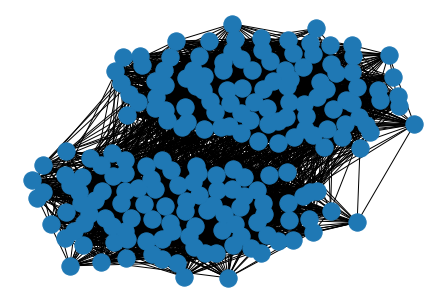

In [3]:
n_number = 100
gaussian1 = [np.random.normal(loc=-0.5) for i in range(n_number-2)]
gaussian2 = [np.random.normal(loc=0.5) for i in range(n_number-2)]
labels = [-1 for i in range(int(n_number))] + [1 for i in range(int(n_number))]
labels = np.array(labels)
partial_label = [0 for i in range(n_number-2)] + [-1,-1] + [0 for i in range(n_number-2)] + [1,1]
G1 = synthetic_clusters(n_list=[n_number, n_number], p=0.3, q=0.05)
adj = np.array(nx.adjacency_matrix(G1).todense()).astype(float)

train_index = [n_number-2, n_number-1, 2*n_number-2, 2*n_number-1]
test_index = list(set([i for i in range(labels.shape[0])])-set(train_index))
train_index = np.array(train_index)
test_index = np.array(test_index)


nx.draw(G1)

ITP++ polarization

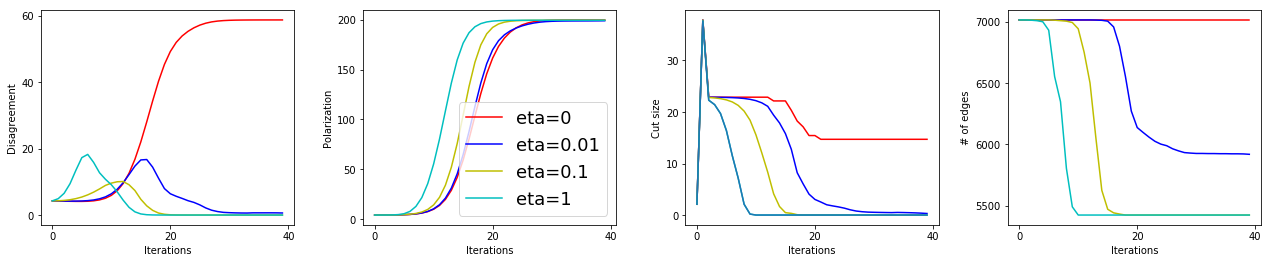

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(18,4))
font = {'size'   : 18}
matplotlib.rc('font', **font)

b = 2
c_list = ['r', 'b', 'y', 'c', 'm']
eta_list = [0, 0.01, 0.1, 1]
for i in range(len(eta_list)):
    bias_dis_list = []
    bias_pola_list = []
    bias_cut_list = []
    pos_size_list = []
    neg_size_list = []
    weight_list = []
    eta = eta_list[i]
    color = c_list[i]
    L = np.array(nx.laplacian_matrix(G1).todense()).astype(float)
    w = np.array(nx.adjacency_matrix(G1).todense()).astype(float)

    self_weight = np.array([0 if i in train_index else 1 for i in range(labels.shape[0])])
    cur_x = np.array([labels[i] if i in train_index else 0 for i in range(labels.shape[0])])

    it = 0
    while it < 40:


        w = update_mat(w, cur_x, eta)
        w = normalized(w)
        g = nx.from_numpy_matrix(w)
        L = np.array(nx.laplacian_matrix(g).todense()).astype(float)
        disagree = np.matmul(np.matmul(cur_x.reshape(1,-1), L), cur_x)[0]
        cut = nx.algorithms.cuts.cut_size(g,np.where(cur_x>0)[0],weight='weight')
        bias_cut_list.append(cut)
        bias_dis_list.append(disagree)
        y_bar = np.average(cur_x)
        polarize = np.linalg.norm(cur_x-y_bar)**2
        bias_pola_list.append(polarize)
        weight_list.append((np.where(w>0)[0].shape[0]))
        pos_size_list.append(np.where(cur_x>0)[0].shape[0])
        neg_size_list.append(np.where(cur_x<0)[0].shape[0])

        previous_x = (cur_x + 1) / 2

        s = np.matmul(previous_x, normalized(w))
        s[np.where(s == 0)] += 0.0001
        s[np.where(s == 1)] -= 0.0001
        cur_x = []
        for i in range(labels.shape[0]):
            nom = self_weight[i] * previous_x[i] + previous_x[i] ** b * s[i]
            deno = self_weight[i] + previous_x[i] ** b * s[i] + (1 - previous_x[i]) ** b * (1 - s[i])
            cur_x.append(nom / deno)
        cur_x = np.array(cur_x)
        cur_x = (cur_x - 0.5) * 2
        it += 1
    axs[0].plot(bias_dis_list, c=color)
    axs[1].plot(bias_pola_list, c=color, label='eta='+str(eta)) 
    axs[2].plot(bias_cut_list, c=color)
    ratio_list = []
    axs[3].plot(weight_list,c=color)

axs[0].set_ylabel('Disagreement')
axs[0].set_xlabel('Iterations')
axs[1].set_ylabel('Polarization')
axs[1].set_xlabel('Iterations')
axs[2].plot(bias_cut_list)
axs[2].set_ylabel('Cut size')
axs[2].set_xlabel('Iterations')
axs[3].set_xlabel('Iterations')
axs[3].set_ylabel('# of edges')
axs[1].legend()
plt.tight_layout()
# plt.savefig('plt/synthetic_byIteration_eta_vary.png')
plt.show()


BOF polarization

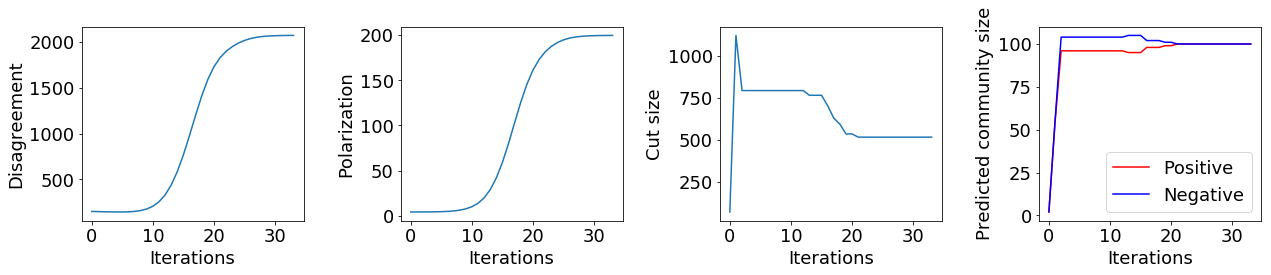

In [5]:
bias_dis_list = []
bias_pola_list = []
bias_cut_list = []
pos_size_list = []
neg_size_list = []
b = 2
temp_label = np.array(labels)
temp_label = (temp_label + 1) / 2
L = np.array(nx.laplacian_matrix(G1).todense()).astype(float)
w = np.array(nx.adjacency_matrix(G1).todense()).astype(float)

self_weight = np.array([0 if i in train_index else 1 for i in range(labels.shape[0])])
previous_x = np.array([temp_label[i] if i in train_index else 0.5 for i in range(labels.shape[0])])

it = 0
while it < 1000:
    previous_x = (previous_x - 0.5) * 2
    
    disagree = np.matmul(np.matmul(previous_x.reshape(1,-1), L), previous_x)[0]
    cut = nx.algorithms.cuts.cut_size(G1,np.where(previous_x>0)[0],weight='weight')
    bias_cut_list.append(cut)
    bias_dis_list.append(disagree)
    y_bar = np.average(previous_x)
    polarize = np.linalg.norm(previous_x-y_bar)**2
    bias_pola_list.append(polarize)
    pos_size_list.append(np.where(previous_x>0)[0].shape[0])
    neg_size_list.append(np.where(previous_x<0)[0].shape[0])
    
    previous_x = (previous_x + 1) / 2
    s = np.matmul(previous_x, normalized(w))
    s[np.where(s == 0)] += 0.0001
    s[np.where(s == 1)] -= 0.0001
    cur_x = []
    for i in range(labels.shape[0]):
        nom = self_weight[i] * previous_x[i] + previous_x[i] ** b * s[i]
        deno = self_weight[i] + previous_x[i] ** b * s[i] + (1 - previous_x[i]) ** b * (1 - s[i])
        cur_x.append(nom / deno)
    cur_x = np.array(cur_x)
    
    if np.abs(previous_x[test_index] - cur_x[test_index]).sum() < 0.01:
        break
    previous_x = np.array(cur_x)
    it += 1
    
fig, axs = plt.subplots(1, 4, figsize=(18,4))
axs[0].plot(bias_dis_list)
axs[0].set_ylabel('Disagreement')
axs[0].set_xlabel('Iterations')
axs[1].plot(bias_pola_list)   
axs[1].set_ylabel('Polarization')
axs[1].set_xlabel('Iterations')
axs[2].plot(bias_cut_list)
axs[2].set_ylabel('Cut size')
axs[2].set_xlabel('Iterations')
axs[3].plot(pos_size_list,color='r', label='Positive')
axs[3].plot(neg_size_list,color='b', label='Negative')
axs[3].set_xlabel('Iterations')
axs[3].set_ylabel('Predicted community size')
axs[3].legend()
plt.tight_layout()
# plt.savefig('plt/synthetic_byIteration_b='+str(b)+'.png')
plt.show()



Polarization in erdos renyi graph

In [11]:
import math
n = 10000
p = 2*math.log(n)/n
# print(p)
er_g = nx.erdos_renyi_graph(n, p)
print("number of connected components in initial erdos renyi graph:", nx.number_connected_components(er_g))

number of connected components in initial erdos renyi graph: 1


In [12]:
highest = 0
index = -1
for i in range(50):
    short = nx.shortest_path_length(er_g, i)
    if highest<max(short.values()):
        index = i
        highest = max(short.values())

short = nx.shortest_path_length(er_g, index)
for i in short:
    if short[i]==highest:
        sink = i
        break
        
w = np.array(nx.adjacency_matrix(er_g).todense()).astype(float)
source = index
pos_nodes = list(er_g[sink]) + [sink]
neg_nodes = list(er_g[source]) + [source]
labels = np.array([0 for i in range(n)])
labels[pos_nodes] = 1
labels[neg_nodes] = -1
unlabel_nodes = np.where(labels==0)[0]
unlabel_nodes
print("duplicated output:")
acc, reg_err, y_pred, it, w_after  = edit_biased_assimilation(w, labels, pos_nodes+neg_nodes, unlabel_nodes, max_it = 5000, eta=10, reg=False, result_graph=True)
print("duplicated output end.")
print("# of iterations run", it)

duplicated output:
classification accuracy 0 0.0 0.0
duplicated output end.
# of iterations run 32


In [13]:
print("In initial erdos renyi graph:")
print('positive node number:', np.where(labels>0)[0].shape)
print('negative node number:', np.where(labels<0)[0].shape)
print('norm of labels:', sum(np.absolute(labels)))

In initial erdos renyi graph:
positive node number: (9,)
negative node number: (19,)
norm of labels: 28


In [14]:
print("In the result graph:")
print('positive node number:', np.where(y_pred>0)[0].shape)
print('negative node number:', np.where(y_pred<0)[0].shape)
print('norm of labels:', sum(np.absolute(y_pred)))
g_edit = nx.from_numpy_array(w_after)
print("number of connected componenets:", nx.number_connected_components(g_edit))

In the result graph:
positive node number: (1569,)
negative node number: (8431,)
norm of labels: 9999.989139828987
number of connected componenets: 2
